# Игровой пример

Это проверка идеи, что нейросеть может научиться на простом DataSet и находить максимум целевой функции
DataSet включает конструктивные параметры Винта, целевая функция есть тяга. Предполагается, что тяга зависит от значений конструктивных параметров и нужно найти такое сочетание значений, которое обеспечивает максимум тяги.

> Конечно, такое можно найти и **простым перебором** всех всех всех возможных сочетаний параметров, но это очень трудоемко и позволяет найти только локальный максимум целевой функции. Применение машинного обучения же в данном случае позволяет найти более менее глобальный максимум быстрее, а также в перспективе выйти за пределы обучающего DataSet. 

#### 1. Начинается все с базового DataSet. 

Есть Винт, у которого можно настроить 3 параметра, каждый в определенном диапазоне: 
* Угол наклона лопасти к оси вращения - от 10 до 80 градусов;
* Количество лопастей - от 2 до 6;
* Радиус закругления вертикального профиля лопасти - от -50 до 30 мм; 

Базовый винт имеет *усредненное* значение параметров: 40 градусов, 3 лопасти и прямой профиль (0 мм закругление) 

In [ ]:
#The base set contain three parameters = {angle of inclined of blade, number of blades, radius of blade curvature}
base_set = [40, 3, 0, 10]

Последним значением в DataSet добавлена тяга в некоторых условных единицах. 
> Значение тяги придумано произвольное (без проверки). Предполагается, что это значение будет получено из модели для этого сочетания параметров. Но пока, для простоты вычислений и проверки гипотезы о возможностях такого применения нейросетей можно значения брать "из головы", сохраняя гладкость зависимости. 

#### 2. Построение частей DataSet для каждого отдельного параметра.

Импорт **Pandas** на будущее и циклами формуруются нужные списки параметров

In [46]:
import pandas as pd

In [47]:
first = []
base_set = [40, 3, 0, 10]
for i in range(2, 7):
    base_set[1], base_set[3] = i, 3*(4 - abs(4-i))+1
    first_int = base_set.copy()
    first.append(first_int)
print(first)

[[40, 2, 0, 7], [40, 3, 0, 10], [40, 4, 0, 13], [40, 5, 0, 10], [40, 6, 0, 7]]


In [48]:
second = []
base_set = [40, 3, 0, 10]
for i in range(10, 85, 10):
    base_set[0], base_set[3] = i, round((-0.0004*i**3 + 0.0366*i**2 - 0.7057**i + 4.2857)/3.7)
    second_int = base_set.copy()
    second.append(second_int)
print(second)

[[10, 3, 0, 2], [20, 3, 0, 4], [30, 3, 0, 7], [40, 3, 0, 10], [50, 3, 0, 12], [60, 3, 0, 13], [70, 3, 0, 13], [80, 3, 0, 9]]


In [49]:
third = []
base_set = [40, 3, 0, 10]
for i in range(-50, 35, 10):
    base_set[2], base_set[3] = i, abs(round(0.0004*i**3 + 0.0016*i**2 - 0.7554*i + 11.444)-1)
    third_int = base_set.copy()
    third.append(third_int)
print(third)

[[40, 3, -50, 2], [40, 3, -40, 18], [40, 3, -30, 24], [40, 3, -20, 23], [40, 3, -10, 18], [40, 3, 0, 10], [40, 3, 10, 3], [40, 3, 20, 1], [40, 3, 30, 0]]


Отдельные "подсписки" сливаются в один общий список, который затем выравнивается (делается плоским) через генератор

In [50]:
res = []
res.append(first)

res.append(second)

res.append(third)

print(res)

[[[40, 2, 0, 7], [40, 3, 0, 10], [40, 4, 0, 13], [40, 5, 0, 10], [40, 6, 0, 7]], [[10, 3, 0, 2], [20, 3, 0, 4], [30, 3, 0, 7], [40, 3, 0, 10], [50, 3, 0, 12], [60, 3, 0, 13], [70, 3, 0, 13], [80, 3, 0, 9]], [[40, 3, -50, 2], [40, 3, -40, 18], [40, 3, -30, 24], [40, 3, -20, 23], [40, 3, -10, 18], [40, 3, 0, 10], [40, 3, 10, 3], [40, 3, 20, 1], [40, 3, 30, 0]]]


In [51]:
# Генератор в генераторе для выравнивания списка двойной вложенности
res = [item for sublist in res for item in sublist]

#### 3. Формирование полного DataFrame

Здесь как раз нужен Pandas, чтобы превратить плоский список параметров и тяги в подлежащий для обучения и наглядный вид

In [52]:
df = pd.DataFrame(res, columns=[ 'angle', 'blades','radius', 'force'])

In [53]:
df

,angle,blades,radius,force
0,40,2,0,7
1,40,3,0,10
2,40,4,0,13
3,40,5,0,10
4,40,6,0,7
5,10,3,0,2
6,20,3,0,4
7,30,3,0,7
8,40,3,0,10
9,50,3,0,12


Здесь следует подробно посмотреть на имеющеся данные. Тяга Винта есть только для каждого отдельного *отклонения* параметра. То есть нет ответа на вопрос **"какая будет тяга если я задам отклонение угла от базового и отклонение радиуса от базового?"**

Можно проиллюстрировать это на графике для имеющихся значений Тяги, угла и радиуса и заданного количества лопастей (3):

In [ ]:
df_3 = df.loc[(df['blades'] == 3)]

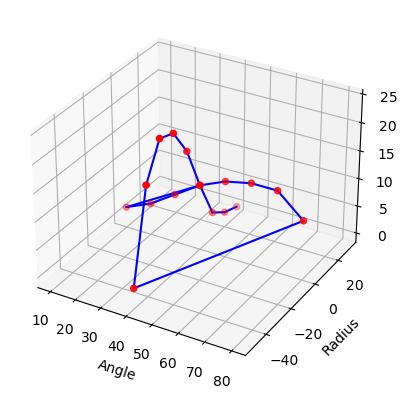

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extracting data
angle = df_3['angle']
radius = df_3['radius']
force = df_3['force']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(angle, radius, force, c='r', marker='o')

# Connect the points with lines
for i in range(1, len(angle)):
    ax.plot(angle[i-1:i+1], radius[i-1:i+1], force[i-1:i+1], linestyle='-', color='b')

# Set labels
ax.set_xlabel('Angle')
ax.set_ylabel('Radius')
ax.set_zlabel('Force')

# Show the plot
plt.show()

Если долго смотреть на график, то можно мысленно представить наличие "одеяла", которое имеет максимум в районе почти минимального радиуса и почти максимального угла. Это одеяло и построит нейросеть

#### 4. Обучение нейросети 

Далее по шагам будет: 

- Подготовка обучающего DataSet; 
- Обучение модели Линейной регресии; 
- Попытка получить результат для произвольного сочетания параметров.

In [54]:
X = df[['angle', 'blades','radius']]  # Features (independent variables)
y = df['force']  # Target variable (dependent variable)

In [55]:
X

,angle,blades,radius
0,40,2,0
1,40,3,0
2,40,4,0
3,40,5,0
4,40,6,0
5,10,3,0
6,20,3,0
7,30,3,0
8,40,3,0
9,50,3,0


In [56]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()  # You can choose a different model based on your data characteristics
model.fit(X, y)

LinearRegression()

In [61]:
X_test = pd.DataFrame([[80, 2, -50]], columns=[ 'angle', 'blades','radius'])

X_test

,angle,blades,radius
0,80,2,-50


Для набора параметров **X_test** получен прогноз Тяги Винта. Максимальный угол, минимальный радиус, две лопасти. Это максимум среди всех наших "одеял". 

In [62]:
model.predict(X_test)

array([31.61298509])

#### 5. Максимум был получен алгоритмом ниже. 

**Важно!!!** Этого максимума не встречалось в обучающем DataSet. То есть, это реально максимум всей области целевой функции

In [43]:
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import numpy as np

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model (replace this with your actual model)
model = LinearRegression()
model.fit(X_train, y_train)

# Objective function to maximize predicted values on the test set
def objective_function(features):
    return -model.predict(np.array(features).reshape(1, -1))

# Initial guess for input features
initial_features = [40, 3, 0]  # Replace with your actual features

# Bounds for features (adjust as needed)
bounds = [(min(X['angle']), max(X['angle'])), (min(X['blades']), max(X['blades'])), (min(X['radius']), max(X['radius']))]

# Optimize the objective function
result = minimize(objective_function, initial_features, bounds=bounds, method='L-BFGS-B')

# Extract the optimized features
optimized_features = result.x

print("Initial Features:", initial_features)
print("Optimized Features:", optimized_features)

Initial Features: [40, 3, 0]
Optimized Features: [ 80.   2. -50.]


D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\DS\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with

#### Выводы. 

Важно понимать, что исходные данные были *тупые* и реальной физики нет здесь. Я сам придумал, что тяга зависит от этих параметров "таким образом", по такому закону. Нейросеть в данном случае просто максимизировала целевую функцию. 
Она нашла такое сочетание параметров для выявленных ею закономерностей, что Тяга Винта получается максимальная. 
Очень хорошим сигналом я считаю то, что она нашла максимум Тяги не из DataSet (24 y.e.), а смогла построить свои регрессионные зависимости и найти максимум тяги для гипотетического сочетания параметром. 
> Правда, это тупая нейросеть, она для совсем простых ситуаций. Для нашего случая максимум тяги не будет скраю одеяла, он может быть где угодно и для этого нужно более умную сеть и более серьзно отнестись к обучению. 

Я предполагаю, что если ей дать реальные данные, побольше данных, то она сможет найти реально самый хороший Винт